# Multithermal OPES expanded for the double-well model

For detail on the OPES method see [this paper](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.10.041034).

Since openmm-plumed does not support using the potential energy as a CV (see [here](https://github.com/openmm/openmm-plumed/issues/53)), we reimplement [OPES_EXPANDED](https://www.plumed.org/doc-master/user-doc/html/_o_p_e_s__e_x_p_a_n_d_e_d.html) in OpenMM, using CustomCVForce. The result is not very fast, but works.

In [1]:
from DoubleWell import *

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
import openmm
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

## run MD

In [4]:
#setup the system
dim = 2**6
n_temps = 6
T_low = 1 / kB
T_high = 5 / kB

modelMD = DoubleWellOpenMM(ModifiedWolfeQuapp(dim))

modelMD.dim, modelMD.MD_dim

(64, 66)

In [5]:
%%time
#setup OPES
temp = (T_high + T_low) / 2 #not the optimal choice
Tmin = T_low - (T_high+T_low)/100 #slightly lower Tmin for better Neff
Tmax = T_high

#initialize useful variables
beta = 1/temp/kB
temperatures = np.geomspace(Tmin, Tmax, n_temps)
df_size = len(temperatures)
running_df = np.zeros(df_size)
rct = 0
counter = 1

#setup things for MD run
pace = 100
integrator = openmm.LangevinMiddleIntegrator(temp*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond)
simulation = openmm.app.Simulation(modelMD.topology, modelMD.system, integrator)
simulation.context.setPositions(modelMD.positions)

#equilibrate the system and intialize the DeltaFs
n_equil = 1000
print('equilibration...', end='\r')
simulation.step(pace*n_equil)
ener = np.zeros(n_equil)
for n in range(n_equil):
    simulation.step(pace)
    ener[n] = simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    print(f'sampling...  {(n+1)/n_equil:.1%}', end='\r')
mean_ener = np.mean(ener)
for i in range(df_size):
    running_df[i] = (temp/temperatures[i]-1) * mean_ener

equil_pos = simulation.context.getState(getPositions=True).getPositions()

#print some info
with np.printoptions(precision=2):
    print('Temperatures:', temperatures*kB)
    # print('Initial DeltaFs:', running_df)
print('Mean energy:', mean_ener)
print()

Temperatures: [0.94 1.31 1.83 2.56 3.58 5.  ]
Mean energy: 99.77960692214965

CPU times: user 2.17 s, sys: 101 ms, total: 2.27 s
Wall time: 2.12 s


In [6]:
# setup biased model using CustomCVForce
import copy

modelOPES = copy.deepcopy(modelMD) #WolfeQuappOpenMM(model)
num_forces = modelOPES.system.getNumForces()

# define bias
ene_str = '('+'+'.join([f'u{k}' for k in range(num_forces)])+')'
bias_str = '-1/beta*log((0'
for i in range(df_size):
    bias_str += f'+exp(beta*((1-temp/{temperatures[i]})*{ene_str}+df{i}))'
bias_str += f')/{df_size}); beta={beta}; temp={temp}'
# print('Bias potential:', bias_str)

# add bias to forces
bias_potential = openmm.CustomCVForce(bias_str)
for i in range(df_size):
    bias_potential.addGlobalParameter(f'df{i}', running_df[i])
ener_group = 0
bias_group = 1
for k in range(num_forces):
    modelOPES.system.getForce(k).setForceGroup(ener_group)
    bias_potential.addCollectiveVariable(f'u{k}', copy.deepcopy(modelOPES.system.getForces()[k]))
modelOPES.system.addForce(bias_potential)
modelOPES.system.getForce(modelOPES.system.getNumForces()-1).setForceGroup(bias_group)

modelOPES.system.getForces()

[<openmm.openmm.CustomExternalForce; proxy of <Swig Object of type 'OpenMM::CustomExternalForce *' at 0x7fa2fd5c1420> >,
 <openmm.openmm.CustomExternalForce; proxy of <Swig Object of type 'OpenMM::CustomExternalForce *' at 0x7fa2fd5c1270> >,
 <openmm.openmm.CustomExternalForce; proxy of <Swig Object of type 'OpenMM::CustomExternalForce *' at 0x7fa2fd5c13f0> >,
 <openmm.openmm.CustomCVForce; proxy of <Swig Object of type 'OpenMM::CustomCVForce *' at 0x7fa2fd5c72a0> >]

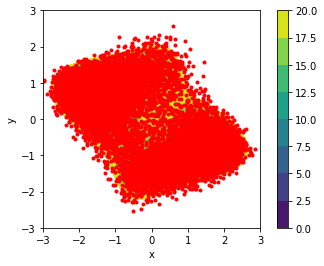

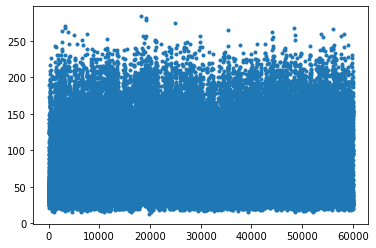

CPU times: user 18min 40s, sys: 3min 58s, total: 22min 38s
Wall time: 18min 39s


In [7]:
%%time
# OPES biased MD run

n_iter = 10_000 * min(10, len(temperatures)) #runs can be shorter than the equivalent REX
integrator = openmm.LangevinIntegrator(temp*unit.kelvin, 10./unit.picosecond, 0.005*unit.picosecond)
simulation = openmm.app.Simulation(modelOPES.topology, modelOPES.system, integrator)
simulation.context.setPositions(equil_pos)

data = np.full((n_iter, 2), np.nan)
ener = np.full(n_iter, np.nan) # needed for reweighting
bias = np.full(n_iter, np.nan) # needed for reweighting
all_df = np.full((n_iter, len(running_df)), np.nan)
all_rct = np.full(n_iter, np.nan)

for n in range(n_iter):
    simulation.step(pace)
    data[n] = np.array(simulation.context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers))[0,:2]
    ener[n] = simulation.context.getState(getEnergy=True, groups={ener_group}).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    bias[n] = simulation.context.getState(getEnergy=True, groups={bias_group}).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    ##### update DeltaFs
    increment = 1/beta*np.log1p(np.exp(beta*(bias[n]-rct))/counter)
    for i in range(df_size):
        diff_i = beta*((1-temp/temperatures[i])*ener[n]+bias[n]-rct+running_df[i])
        running_df[i] += increment - 1/beta*np.log1p(np.exp(diff_i)/counter)
        simulation.context.setParameter(f'df{i}', running_df[i])
    counter += 1
    rct += increment + 1/beta*np.log1p(-1/counter)
    ##### 
    all_df[n] = running_df
    all_rct[n] = rct
    # print info
    if (n+1) % (n_iter//10) == 0:
        clear_output(wait=True)
        plot_doublewell(data[:n+1])
        # plt.plot(ener, '.')
        # plt.show()
    print(f'sampling...  {n/n_iter:.3%}', end='\r')

## check results

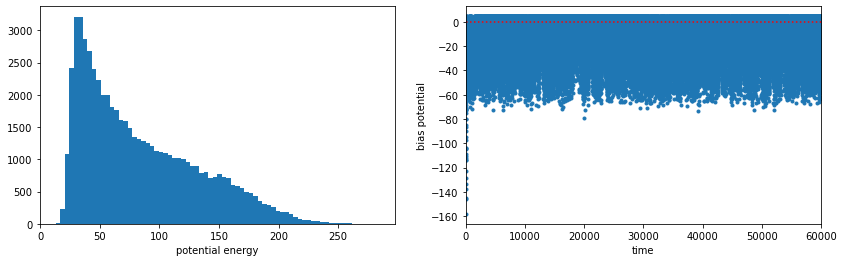

FES at T=3


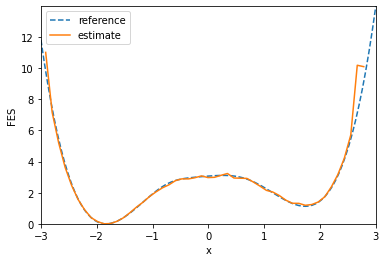

ref DeltaF: 0.968272 [kBT]
    DeltaF: 1.01221 [kBT]


In [19]:
# more plotting
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.hist(ener, bins='auto')
plt.xlabel('potential energy')

plt.subplot(1,2,2)
plt.plot(bias, '.')
plt.axhline(0, c='r', ls=':')
plt.xlim(0, len(bias))
plt.ylabel('bias potential')
plt.xlabel('time')
plt.show()

print(f'FES at T={temp*kB:g}')
plot_fes(data[:,0], w=np.exp(bias/(temp*kB)), temp=temp)

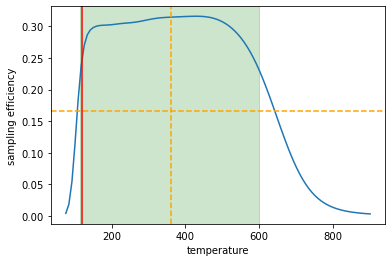

      REX Sampling efficiency: 0.166667
Sampling efficiency at T=1.00: 0.252306
 Effective sample size T=1.00: 14886.1


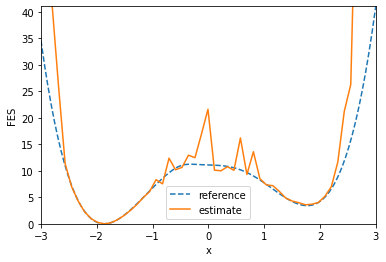

ref DeltaF: 3.31506 [kBT]
    DeltaF: 3.47439 [kBT]


In [20]:
transient = 1_000
myT = 1/kB
myx = data[transient:,0]
mybias = bias[transient:]
myener = ener[transient:]

def sampling_efficiency(logw):
    return np.exp(2*np.logaddexp.reduce(logw)-np.logaddexp.reduce(2*logw))/len(logw)

temp_range = np.linspace(Tmin/1.5, Tmax*1.5, 100)
SEs = np.array([ sampling_efficiency(beta*((1-temp/t)*myener+mybias)) for t in temp_range])
plt.plot(temp_range, SEs)
plt.axhline(1/len(temperatures), ls='--', c='orange')
plt.axvspan(Tmin, Tmax, color='green', alpha=0.2)
plt.axvline(x=temp, ls='--', c='orange')
plt.axvline(x=myT, c='red')
plt.xlabel("temperature")
plt.ylabel("sampling efficiency")
# plt.ylim(0,1)
plt.show()

logw = beta * ((1 - temp / myT) * myener + mybias)
print(f'      REX Sampling efficiency: {1/len(temperatures):g}')
print(f'Sampling efficiency at T={myT*kB:.2f}: {sampling_efficiency(logw):g}')
print(f' Effective sample size T={myT*kB:.2f}: {sampling_efficiency(logw)*len(logw):g}')

plot_fes(myx, w=np.exp(logw), temp=myT)